<a href="https://colab.research.google.com/github/ad5454/BitPredict/blob/main/Bit_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-434583fd-922f-dcb5-b3d3-f63b3ffed099)


## Getting thedata
\



In [2]:
# Download Bitcoin historical data from GitHub
# Note: you'll need to select "Raw" to download the data in the correct format
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-07-04 05:52:09--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: â€˜BTC_USD_2013-10-01_2021-05-18-CoinDesk.csvâ€™

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.03s   

2023-07-04 05:52:09 (5.11 MB/s) - â€˜BTC_USD_2013-10-01_2021-05-18-CoinDesk.csvâ€™ saved [178509/178509]



### Importing time series data with pandas


In [3]:
# Import with pandas
import pandas as pd
# Parse dates and set date column to index
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

Currency  Closing Price (USD)  24h Open (USD)  24h High (USD)  \
Date                                                                       
2013-10-01      BTC            123.65499       124.30466       124.75166   
2013-10-02      BTC            125.45500       123.65499       125.75850   
2013-10-03      BTC            108.58483       125.45500       125.66566   
2013-10-04      BTC            118.67466       108.58483       118.67500   
2013-10-05      BTC            121.33866       118.67466       121.93633   

            24h Low (USD)  
Date                       
2013-10-01      122.56349  
2013-10-02      123.63383  
2013-10-03       83.32833  
2013-10-04      107.05816  
2013-10-05      118.00566

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


Because we told pandas to parse the date column and set it as the index, its not in the list of columns.

You can also see there isn't many samples.

In [5]:
# How many samples do we have?
len(df)

2787

In [6]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

Price
Date                 
2013-10-01  123.65499
2013-10-02  125.45500
2013-10-03  108.58483
2013-10-04  118.67466
2013-10-05  121.33866

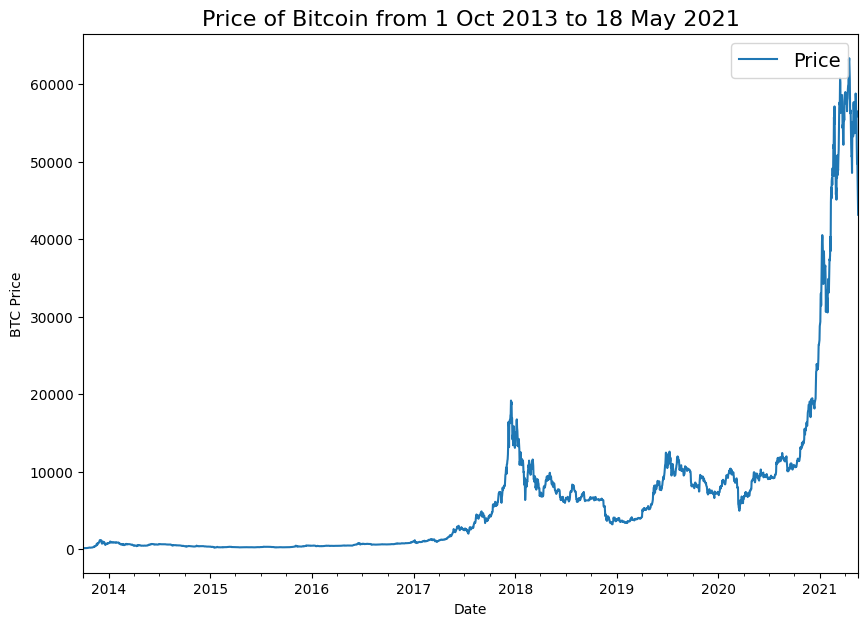

In [7]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

In [8]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",") # read in the target CSV
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings), strptime = string parse time
    btc_price.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

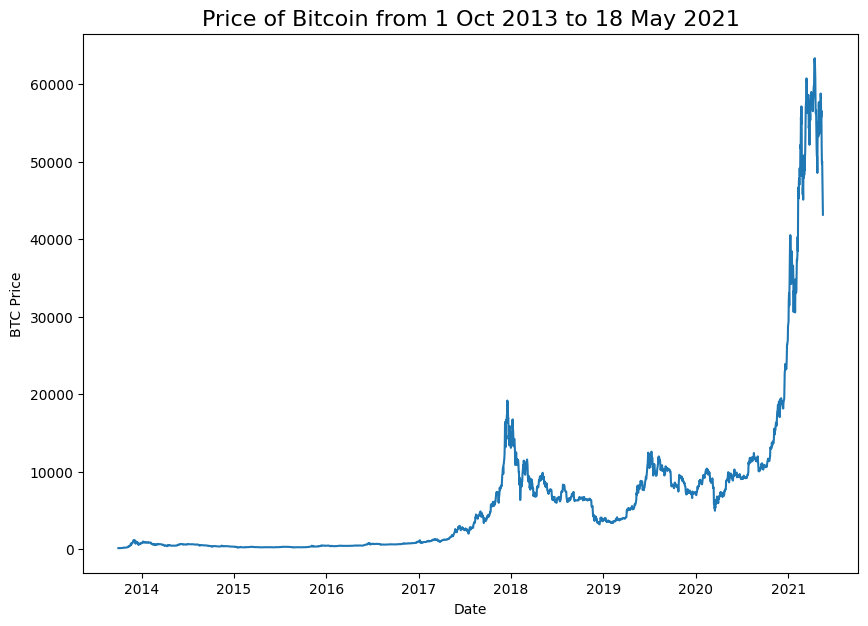

In [9]:
# Plot from CSV
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.xlabel("Date")
plt.ylabel("BTC Price");

## Format Data Part 1: Creatining train and test sets for time series data



In [10]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

### Create train & test sets for time series (the right way)

Of course, there's no way we can actually access data from the future.

But we can engineer our test set to be in the future with respect to the training set.

To do this, we can create an abitrary point in time to split our data.

Everything before the point in time can be considered the training set and everything after the point in time can be considered the test set.

In [11]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

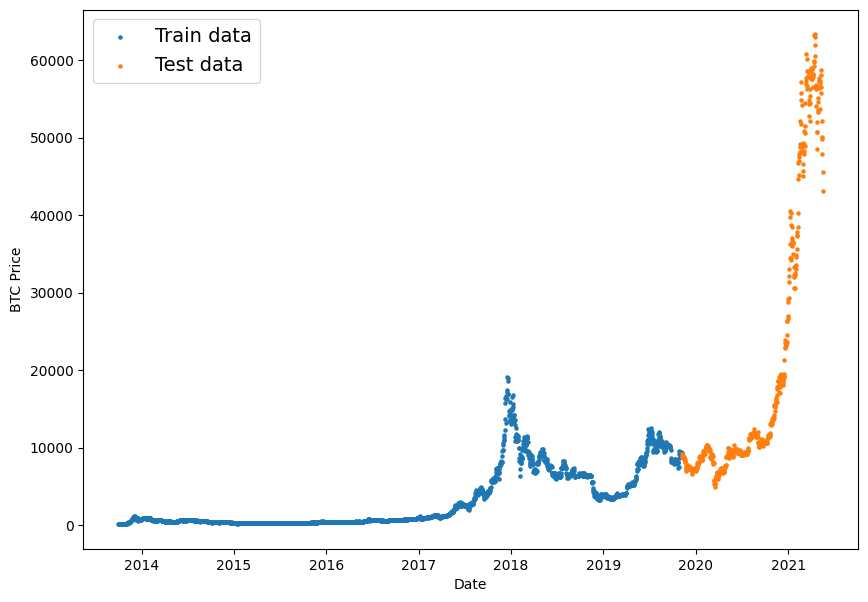

In [12]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

### Create a plotting function

Rather than retyping `matplotlib` commands to continuously plot data, let's make a plotting function we can reuse later.

In [13]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

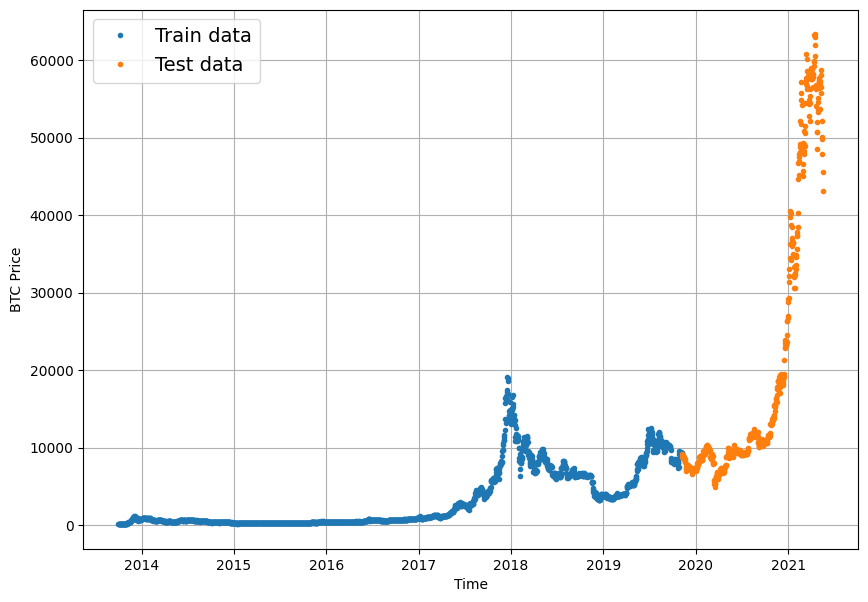

In [14]:
# Try out our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Model 0:Naive Forecast (Baseline)

In [15]:
# Create a naÃ¯ve forecast
naive_forecast = y_test[:-1] # NaÃ¯ve forecast equals every value excluding the last value
naive_forecast[:10], naive_forecast[-10:] # View frist 10 and last 10

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

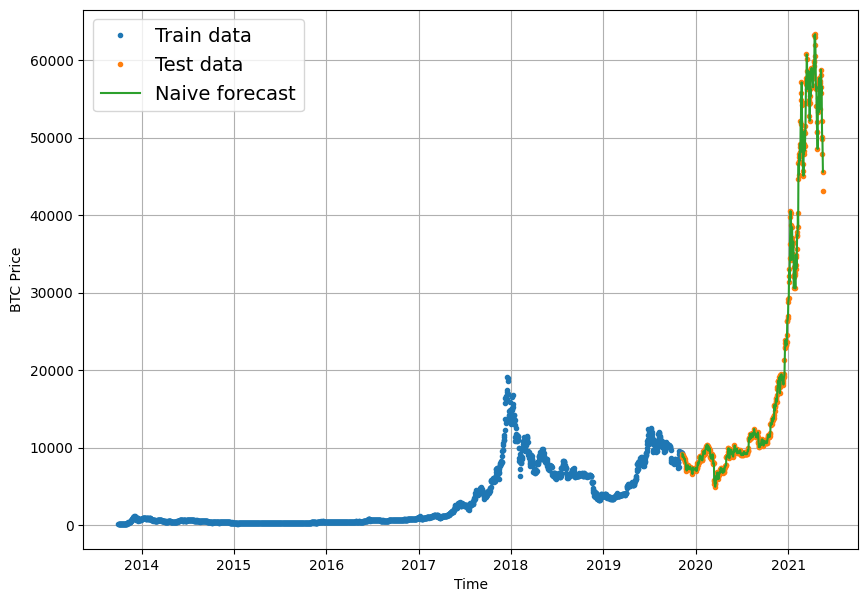

In [16]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");

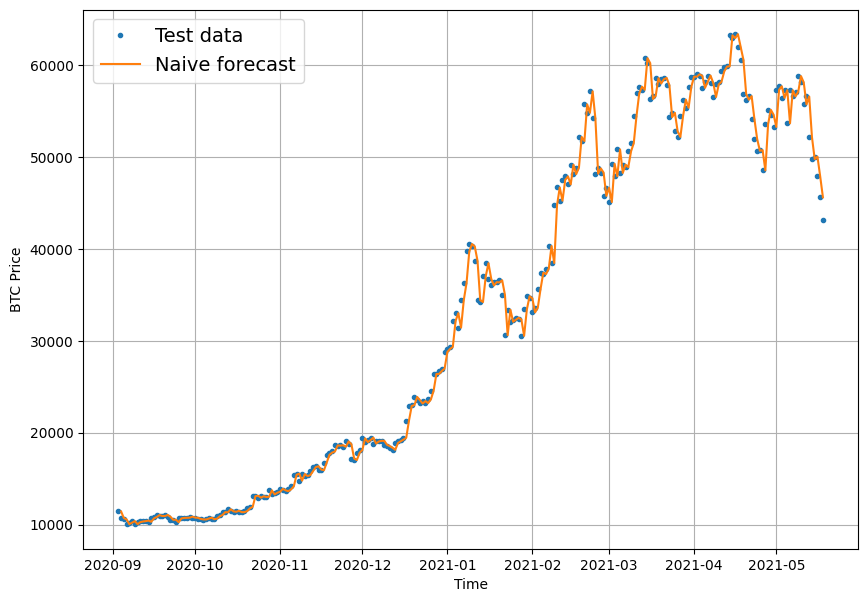

In [17]:
plt.figure(figsize=(10, 7))
offset = 300 # offset the values by 300 timesteps
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

## Evaluating the time series model



In [18]:
# Let's get TensorFlow!
import tensorflow as tf

In [19]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

In [20]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [21]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

In [22]:
# Find average price of Bitcoin in test dataset
tf.reduce_mean(y_test).numpy()

20056.632963737222

## Format Data Part 2: Windowing dataset

In [23]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

In [24]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [25]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


In [26]:
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [27]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [28]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [29]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


In [30]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [31]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [32]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [33]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint


In [34]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

## Model 1: Dense model (window = 7, horizon = 1)

In [35]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation
], name="model_1_dense") # give the model a name so we can save it

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# Fit model
model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to save best model

Epoch 1/100
15/18 [========================>.....] - ETA: 0s - loss: 1210.2593 - mae: 1210.2593

18/18 [==============================] - 12s 120ms/step - loss: 1096.4707 - mae: 1096.4707 - val_loss: 2638.0759 - val_mae: 2638.0759
Epoch 2/100
 9/18 [==============>...............] - ETA: 0s - loss: 278.1061 - mae: 278.1061

18/18 [==============================] - 2s 105ms/step - loss: 246.7534 - mae: 246.7534 - val_loss: 783.4589 - val_mae: 783.4589
Epoch 3/100
18/18 [==============================] - ETA: 0s - loss: 147.1509 - mae: 147.1509

18/18 [==============================] - 1s 83ms/step - loss: 147.1509 - mae: 147.1509 - val_loss: 753.5380 - val_mae: 753.5380
Epoch 4/100
17/18 [===========================>..] - ETA: 0s - loss: 138.8319 - mae: 138.8319

18/18 [==============================] - 1s 67ms/step - loss: 137.5294 - mae: 137.5294 - val_loss: 748.8157 - val_mae: 748.8157
Epoch 5/100
13/18 [====================>.........] - ETA: 0s - loss: 137.8109 - mae: 137.8109

18/18 [==============================] - 1s 62ms/step - loss: 135.4382 - mae: 135.4382 - val_loss: 736.7340 - val_mae: 736.7340
Epoch 6/100
13/18 [====================>.........] - ETA: 0s - loss: 131.4158 - mae: 131.4158

18/18 [==============================] - 1s 68ms/step - loss: 135.5308 - mae: 135.5308 - val_loss: 723.6138 - val_mae: 723.6137
Epoch 7/100
12/18 [===================>..........] - ETA: 0s - loss: 135.1069 - mae: 135.1069

18/18 [==============================] - 1s 75ms/step - loss: 132.1754 - mae: 132.1754 - val_loss: 712.2100 - val_mae: 712.2100
Epoch 8/100
18/18 [==============================] - 0s 12ms/step - loss: 129.6451 - mae: 129.6451 - val_loss: 716.3796 - val_mae: 716.3796
Epoch 9/100
18/18 [==============================] - 0s 15ms/step - loss: 132.6018 - mae: 132.6018 - val_loss: 739.7354 - val_mae: 739.7354
Epoch 10/100
13/18 [====================>.........] - ETA: 0s - loss: 125.5532 - mae: 125.5532

18/18 [==============================] - 2s 119ms/step - loss: 128.8860 - mae: 128.8860 - val_loss: 694.0919 - val_mae: 694.0919
Epoch 11/100
17/18 [===========================>..] - ETA: 0s - loss: 125.6228 - mae: 125.6228

18/18 [==============================] - 1s 81ms/step - loss: 125.3000 - mae: 125.3000 - val_loss: 687.7082 - val_mae: 687.7082
Epoch 12/100
18/18 [==============================] - 0s 14ms/step - loss: 125.9795 - mae: 125.9795 - val_loss: 690.7255 - val_mae: 690.7255
Epoch 13/100
18/18 [==============================] - 0s 10ms/step - loss: 126.0102 - mae: 126.0102 - val_loss: 723.7615 - val_mae: 723.7615
Epoch 14/100
18/18 [==============================] - 0s 9ms/step - loss: 122.2373 - mae: 122.2373 - val_loss: 699.7990 - val_mae: 699.7990
Epoch 15/100
12/18 [===================>..........] - ETA: 0s - loss: 116.3801 - mae: 116.3801

18/18 [==============================] - 1s 80ms/step - loss: 122.7642 - mae: 122.7642 - val_loss: 656.2625 - val_mae: 656.2625
Epoch 16/100
18/18 [==============================] - 0s 6ms/step - loss: 119.8438 - mae: 119.8438 - val_loss: 668.3945 - val_mae: 668.3945
Epoch 17/100
18/18 [==============================] - 0s 6ms/step - loss: 118.8485 - mae: 118.8485 - val_loss: 664.7589 - val_mae: 664.7589
Epoch 18/100
17/18 [===========================>..] - ETA: 0s - loss: 119.9546 - mae: 119.9546

18/18 [==============================] - 1s 35ms/step - loss: 119.0922 - mae: 119.0922 - val_loss: 643.0283 - val_mae: 643.0283
Epoch 19/100
18/18 [==============================] - 0s 6ms/step - loss: 118.8100 - mae: 118.8100 - val_loss: 673.1353 - val_mae: 673.1353
Epoch 20/100
17/18 [===========================>..] - ETA: 0s - loss: 116.7967 - mae: 116.7967

18/18 [==============================] - 1s 36ms/step - loss: 116.8368 - mae: 116.8368 - val_loss: 636.8077 - val_mae: 636.8077
Epoch 21/100
16/18 [=========================>....] - ETA: 0s - loss: 118.2920 - mae: 118.2920

18/18 [==============================] - 1s 35ms/step - loss: 119.0087 - mae: 119.0087 - val_loss: 629.4539 - val_mae: 629.4539
Epoch 22/100
17/18 [===========================>..] - ETA: 0s - loss: 116.9587 - mae: 116.9587

18/18 [==============================] - 1s 50ms/step - loss: 116.8021 - mae: 116.8021 - val_loss: 627.5461 - val_mae: 627.5461
Epoch 23/100
16/18 [=========================>....] - ETA: 0s - loss: 115.6350 - mae: 115.6350

18/18 [==============================] - 1s 36ms/step - loss: 116.4359 - mae: 116.4359 - val_loss: 623.9669 - val_mae: 623.9669
Epoch 24/100
18/18 [==============================] - ETA: 0s - loss: 115.3753 - mae: 115.3753

18/18 [==============================] - 1s 34ms/step - loss: 115.3753 - mae: 115.3753 - val_loss: 619.2134 - val_mae: 619.2134
Epoch 25/100
18/18 [==============================] - 0s 6ms/step - loss: 114.6958 - mae: 114.6958 - val_loss: 626.5401 - val_mae: 626.5401
Epoch 26/100
16/18 [=========================>....] - ETA: 0s - loss: 119.5152 - mae: 119.5152

18/18 [==============================] - 1s 38ms/step - loss: 117.5925 - mae: 117.5925 - val_loss: 618.2653 - val_mae: 618.2653
Epoch 27/100
18/18 [==============================] - 0s 6ms/step - loss: 116.0388 - mae: 116.0388 - val_loss: 618.3679 - val_mae: 618.3679
Epoch 28/100
15/18 [========================>.....] - ETA: 0s - loss: 112.3977 - mae: 112.3977

18/18 [==============================] - 1s 35ms/step - loss: 113.9796 - mae: 113.9796 - val_loss: 607.9081 - val_mae: 607.9081
Epoch 29/100
18/18 [==============================] - 0s 6ms/step - loss: 112.4588 - mae: 112.4588 - val_loss: 626.1744 - val_mae: 626.1744
Epoch 30/100
17/18 [===========================>..] - ETA: 0s - loss: 117.9487 - mae: 117.9487

18/18 [==============================] - 1s 35ms/step - loss: 117.3016 - mae: 117.3016 - val_loss: 607.2608 - val_mae: 607.2608
Epoch 31/100
18/18 [==============================] - 0s 7ms/step - loss: 115.1835 - mae: 115.1835 - val_loss: 654.7257 - val_mae: 654.7257
Epoch 32/100
18/18 [==============================] - 0s 5ms/step - loss: 113.6825 - mae: 113.6825 - val_loss: 612.2707 - val_mae: 612.2707
Epoch 33/100
18/18 [==============================] - 0s 6ms/step - loss: 112.9947 - mae: 112.9947 - val_loss: 636.4670 - val_mae: 636.4670
Epoch 34/100
18/18 [==============================] - 0s 6ms/step - loss: 112.5939 - mae: 112.5939 - val_loss: 612.6216 - val_mae: 612.6216
Epoch 35/100
15/18 [========================>.....] - ETA: 0s - loss: 113.3564 - mae: 113.3564

18/18 [==============================] - 1s 50ms/step - loss: 111.2359 - mae: 111.2359 - val_loss: 594.4922 - val_mae: 594.4922
Epoch 36/100
18/18 [==============================] - 0s 9ms/step - loss: 115.5341 - mae: 115.5341 - val_loss: 596.3594 - val_mae: 596.3594
Epoch 37/100
18/18 [==============================] - 0s 8ms/step - loss: 111.0361 - mae: 111.0361 - val_loss: 600.5273 - val_mae: 600.5273
Epoch 38/100
18/18 [==============================] - 0s 8ms/step - loss: 111.8141 - mae: 111.8141 - val_loss: 608.0778 - val_mae: 608.0778
Epoch 39/100
12/18 [===================>..........] - ETA: 0s - loss: 113.8365 - mae: 113.8365

18/18 [==============================] - 1s 50ms/step - loss: 111.8981 - mae: 111.8981 - val_loss: 587.2688 - val_mae: 587.2688
Epoch 40/100
18/18 [==============================] - 0s 8ms/step - loss: 110.6126 - mae: 110.6126 - val_loss: 591.1821 - val_mae: 591.1821
Epoch 41/100
18/18 [==============================] - 0s 9ms/step - loss: 111.9070 - mae: 111.9070 - val_loss: 650.7516 - val_mae: 650.7516
Epoch 42/100
18/18 [==============================] - 0s 8ms/step - loss: 116.2375 - mae: 116.2375 - val_loss: 626.0896 - val_mae: 626.0896
Epoch 43/100
18/18 [==============================] - 0s 7ms/step - loss: 115.8039 - mae: 115.8039 - val_loss: 646.0764 - val_mae: 646.0764
Epoch 44/100
18/18 [==============================] - 0s 6ms/step - loss: 119.3256 - mae: 119.3256 - val_loss: 630.6774 - val_mae: 630.6774
Epoch 45/100
18/18 [==============================] - 0s 6ms/step - loss: 111.8186 - mae: 111.8186 - val_loss: 587.7781 - val_mae: 587.7781
Epoch 46/100
16/18 [============

18/18 [==============================] - 1s 35ms/step - loss: 111.5074 - mae: 111.5074 - val_loss: 584.3677 - val_mae: 584.3677
Epoch 47/100
18/18 [==============================] - 0s 6ms/step - loss: 110.9902 - mae: 110.9902 - val_loss: 641.2890 - val_mae: 641.2890
Epoch 48/100
18/18 [==============================] - 0s 6ms/step - loss: 109.8377 - mae: 109.8377 - val_loss: 604.7910 - val_mae: 604.7910
Epoch 49/100
18/18 [==============================] - 0s 6ms/step - loss: 111.0142 - mae: 111.0142 - val_loss: 620.6592 - val_mae: 620.6592
Epoch 50/100
18/18 [==============================] - 0s 6ms/step - loss: 115.4366 - mae: 115.4366 - val_loss: 617.2062 - val_mae: 617.2062
Epoch 51/100
18/18 [==============================] - 0s 6ms/step - loss: 110.9162 - mae: 110.9162 - val_loss: 597.3513 - val_mae: 597.3513
Epoch 52/100
18/18 [==============================] - 0s 6ms/step - loss: 112.5361 - mae: 112.5361 - val_loss: 585.1648 - val_mae: 585.1648
Epoch 53/100
18/18 [============

18/18 [==============================] - 1s 35ms/step - loss: 112.4920 - mae: 112.4920 - val_loss: 574.6183 - val_mae: 574.6183
Epoch 55/100
18/18 [==============================] - 0s 6ms/step - loss: 111.7402 - mae: 111.7402 - val_loss: 600.4590 - val_mae: 600.4590
Epoch 56/100
18/18 [==============================] - 0s 6ms/step - loss: 113.7053 - mae: 113.7053 - val_loss: 843.9615 - val_mae: 843.9615
Epoch 57/100
18/18 [==============================] - 0s 6ms/step - loss: 138.1036 - mae: 138.1036 - val_loss: 677.1609 - val_mae: 677.1609
Epoch 58/100
18/18 [==============================] - 0s 6ms/step - loss: 120.2165 - mae: 120.2165 - val_loss: 690.5374 - val_mae: 690.5374
Epoch 59/100
18/18 [==============================] - 0s 6ms/step - loss: 110.4928 - mae: 110.4928 - val_loss: 575.8503 - val_mae: 575.8503
Epoch 60/100
18/18 [==============================] - 0s 6ms/step - loss: 108.3432 - mae: 108.3432 - val_loss: 579.2704 - val_mae: 579.2704
Epoch 61/100
18/18 [============

18/18 [==============================] - 1s 35ms/step - loss: 109.4167 - mae: 109.4167 - val_loss: 570.7270 - val_mae: 570.7270
Epoch 66/100
17/18 [===========================>..] - ETA: 0s - loss: 107.3891 - mae: 107.3891

18/18 [==============================] - 1s 36ms/step - loss: 107.0355 - mae: 107.0355 - val_loss: 570.7028 - val_mae: 570.7028
Epoch 67/100
18/18 [==============================] - 0s 6ms/step - loss: 106.9770 - mae: 106.9770 - val_loss: 615.3275 - val_mae: 615.3275
Epoch 68/100
18/18 [==============================] - 0s 6ms/step - loss: 115.1812 - mae: 115.1812 - val_loss: 728.5147 - val_mae: 728.5147
Epoch 69/100
18/18 [==============================] - 0s 6ms/step - loss: 126.1517 - mae: 126.1517 - val_loss: 646.9493 - val_mae: 646.9493
Epoch 70/100
18/18 [==============================] - 0s 6ms/step - loss: 127.7468 - mae: 127.7468 - val_loss: 575.8583 - val_mae: 575.8583
Epoch 71/100
18/18 [==============================] - 0s 6ms/step - loss: 112.2565 - mae: 112.2565 - val_loss: 603.6755 - val_mae: 603.6755
Epoch 72/100
18/18 [==============================] - ETA: 0s - loss: 109.3167 - mae: 109.3167

18/18 [==============================] - 1s 35ms/step - loss: 109.3167 - mae: 109.3167 - val_loss: 570.3442 - val_mae: 570.3442
Epoch 73/100
18/18 [==============================] - 0s 6ms/step - loss: 111.0074 - mae: 111.0074 - val_loss: 583.9255 - val_mae: 583.9255
Epoch 74/100
18/18 [==============================] - 0s 7ms/step - loss: 109.1670 - mae: 109.1670 - val_loss: 573.1542 - val_mae: 573.1542
Epoch 75/100
18/18 [==============================] - 0s 7ms/step - loss: 109.4573 - mae: 109.4573 - val_loss: 590.6826 - val_mae: 590.6826
Epoch 76/100
18/18 [==============================] - 0s 6ms/step - loss: 109.2075 - mae: 109.2075 - val_loss: 592.3623 - val_mae: 592.3623
Epoch 77/100
18/18 [==============================] - 0s 6ms/step - loss: 108.9297 - mae: 108.9297 - val_loss: 578.7767 - val_mae: 578.7767
Epoch 78/100
18/18 [==============================] - 0s 6ms/step - loss: 108.5265 - mae: 108.5265 - val_loss: 574.3221 - val_mae: 574.3221
Epoch 79/100
18/18 [============

18/18 [==============================] - 1s 35ms/step - loss: 106.8175 - mae: 106.8175 - val_loss: 568.4521 - val_mae: 568.4521
Epoch 82/100
18/18 [==============================] - 0s 6ms/step - loss: 115.7670 - mae: 115.7670 - val_loss: 571.2460 - val_mae: 571.2460
Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 112.0653 - mae: 112.0653 - val_loss: 664.2952 - val_mae: 664.2952
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 111.9914 - mae: 111.9914 - val_loss: 579.9096 - val_mae: 579.9096
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 107.3769 - mae: 107.3769 - val_loss: 588.6234 - val_mae: 588.6234
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 108.2788 - mae: 108.2788 - val_loss: 575.2352 - val_mae: 575.2352
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 105.9013 - mae: 105.9013 - val_loss: 595.3911 - val_mae: 595.3911
Epoch 88/100
18/18 [============

18/18 [==============================] - 1s 35ms/step - loss: 106.7847 - mae: 106.7847 - val_loss: 567.9766 - val_mae: 567.9766
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 106.2380 - mae: 106.2380 - val_loss: 580.6459 - val_mae: 580.6459
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 111.3396 - mae: 111.3396 - val_loss: 627.2155 - val_mae: 627.2155
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 109.6163 - mae: 109.6163 - val_loss: 584.8616 - val_mae: 584.8616
Epoch 93/100
18/18 [==============================] - 0s 6ms/step - loss: 116.0122 - mae: 116.0122 - val_loss: 622.1790 - val_mae: 622.1790
Epoch 94/100
18/18 [==============================] - 0s 6ms/step - loss: 110.0068 - mae: 110.0068 - val_loss: 587.1557 - val_mae: 587.1557
Epoch 95/100
18/18 [==============================] - 0s 6ms/step - loss: 106.0953 - mae: 106.0953 - val_loss: 569.5912 - val_mae: 569.5912
Epoch 96/100
18/18 [============

18/18 [==============================] - 1s 71ms/step - loss: 107.0041 - mae: 107.0041 - val_loss: 566.9385 - val_mae: 566.9385
Epoch 100/100
18/18 [==============================] - 0s 9ms/step - loss: 108.7888 - mae: 108.7888 - val_loss: 596.2381 - val_mae: 596.2381


In [36]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 596.2381 - mae: 596.2381


[596.2380981445312, 596.2380981445312]

In [37]:
# Load in saved best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 566.9385 - mae: 566.9385


[566.9385375976562, 566.9385375976562]

## Making forecasts with a model (on the test dataset)




In [38]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [39]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 2ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8877.529, 8794.475, 9054.495, 8806.412, 8742.926, 8758.728,
        8706.641, 8531.506, 8480.761, 8545.287], dtype=float32)>)

In [40]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 566.93854,
 'mse': 1165641.8,
 'rmse': 1079.6489,
 'mape': 2.5327604,
 'mase': 0.995954}

In [41]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

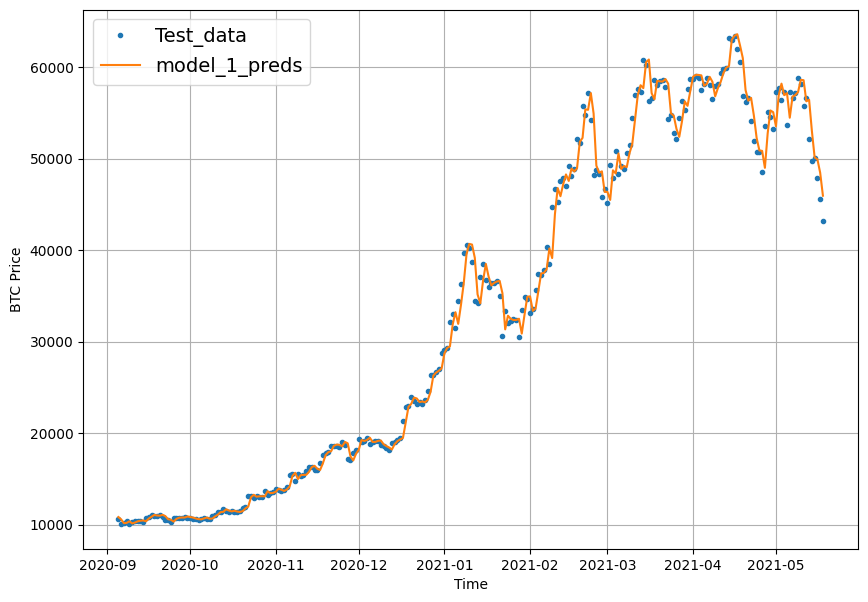

In [42]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

## Model 2: Dense (window = 30, horizon = 1)


In [43]:
HORIZON = 1 # predict one step at a time
WINDOW_SIZE = 30 # use 30 timesteps in the past

In [44]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [45]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [46]:
tf.random.set_seed(42)

# Create model (same model as model 1 but data input will be different)
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON) # need to predict horizon number of steps into the future
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [47]:
# Evaluate model 2 preds
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 603.8980


603.8980102539062

In [48]:
# Load in best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 603.8980


603.8980102539062

In [49]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

18/18 [==============================] - 0s 2ms/step


In [50]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), # remove 1 dimension of test labels
                                 y_pred=model_2_preds)
model_2_results

{'mae': 603.898,
 'mse': 1229238.8,
 'rmse': 1108.7103,
 'mape': 2.7851868,
 'mase': 1.0556197}

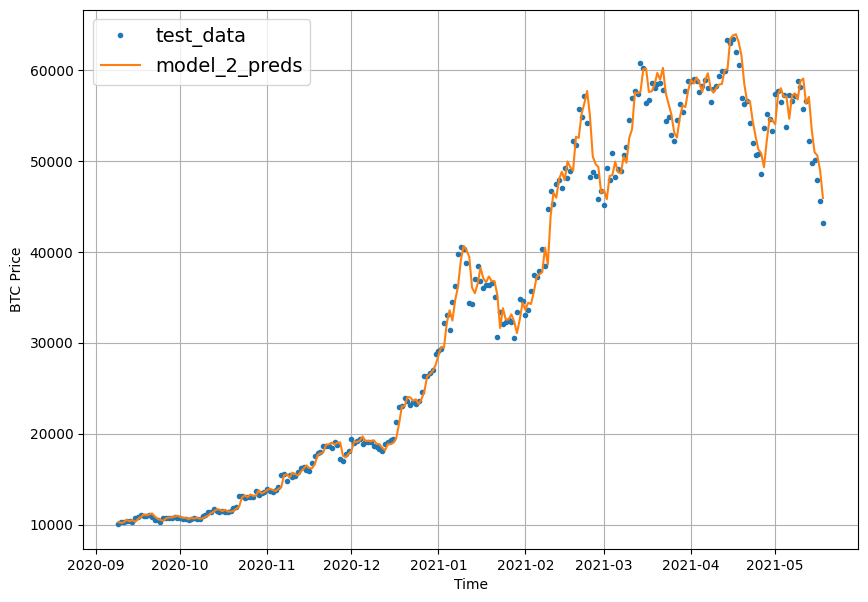

In [51]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

## Model 3: Dense (window = 30, horizon = 7)

In [52]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [53]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [54]:
tf.random.set_seed(42)

# Create model (same as model_1 except with different data input size)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [55]:
# How did our model with a larger window size and horizon go?
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1400.8179


1400.81787109375

In [56]:
# Load in best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1235.9739


1235.973876953125

In [57]:
# The predictions are going to be 7 steps at a time (this is the HORIZON size)
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9284.414 , 9471.818 , 9610.242 , 9581.312 , 9722.215 , 9538.826 ,
        9551.496 ],
       [9146.718 , 9353.656 , 9325.848 , 9383.337 , 9447.754 , 9350.649 ,
        9275.359 ],
       [8940.698 , 9175.605 , 9111.199 , 9354.782 , 9231.575 , 9271.07  ,
        9149.726 ],
       [9084.834 , 9167.221 , 9157.527 , 9439.9795, 9082.321 , 9519.143 ,
        9171.265 ],
       [9016.781 , 8961.149 , 9096.106 , 9070.131 , 8807.38  , 9440.994 ,
        8970.386 ]], dtype=float32)>

In [58]:
# Calculate model_3 results - these are going to be multi-dimensional because
# we're trying to predict more than one step at a time.
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([  743.97406 ,   574.93304 ,   512.232   ,   605.16113 ,
          497.49902 ,   553.5073  ,   598.95593 ,   559.9891  ,
          646.45013 ,   687.27704 ,   834.62213 ,   832.5795  ,
          956.5597  ,   912.4863  ,   701.63043 ,   303.86285 ,
          173.89767 ,   164.25475 ,   183.27148 ,   187.32248 ,
          159.53062 ,   241.26137 ,   388.33838 ,   383.0505  ,
          266.36914 ,   167.49637 ,   147.63455 ,   142.8932  ,
          171.42467 ,   187.9481  ,   265.521   ,   406.09955 ,
          285.8813  ,   344.24713 ,   294.5798  ,   315.5669  ,
          378.2892  ,   252.50627 ,   184.07129 ,   184.27504 ,
          443.7334  ,    80.20912 ,    83.438194,   128.17293 ,
          171.8157  ,   114.958145,   109.96275 ,   145.24184 ,
          107.41302 ,   113.558105,   159.72119 ,   156.75635 ,
          229.10938 ,   217.71484 ,   237.19922 ,   316.79303 ,
          481.71094 ,   486.36334 ,   432.81662 ,   501.33035 ,
          287.9317  ,   207.074  

## Make our evaluation function work for larger horizons

In [59]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [60]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1235.974,
 'mse': 5406065.5,
 'rmse': 1429.7828,
 'mape': 5.640371,
 'mase': 2.1993468}

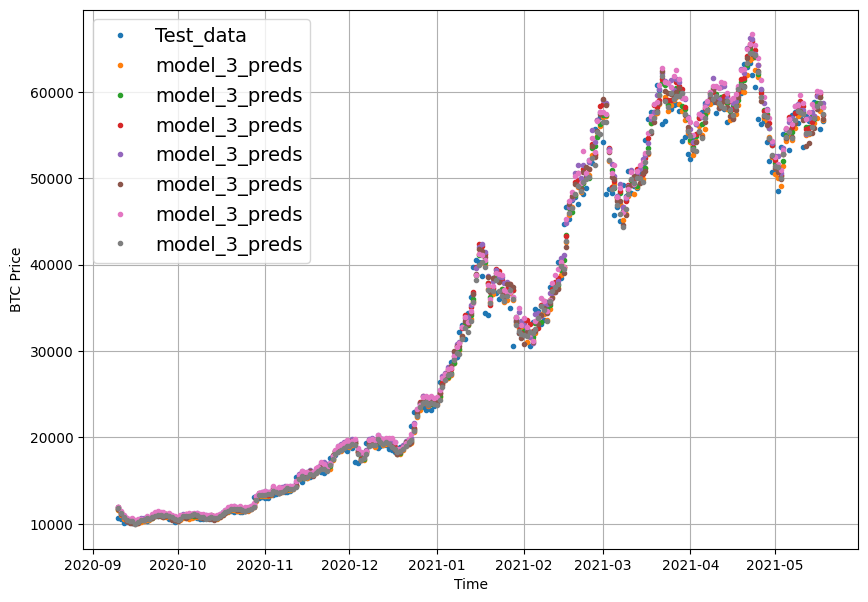

In [61]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
# Checking the shape of model_3_preds results in [n_test_samples, HORIZON] (this will screw up the plot)
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

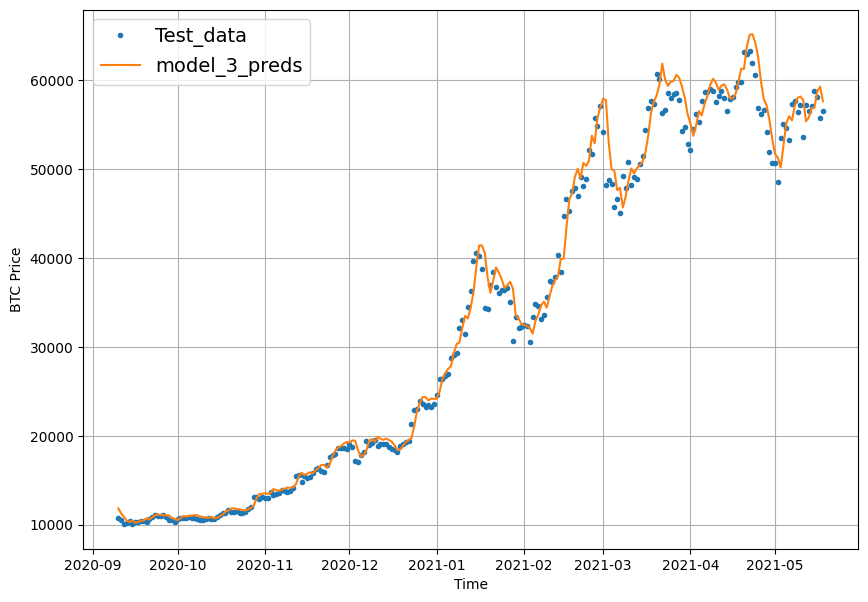

In [62]:
offset = 300
plt.figure(figsize=(10, 7))
# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look fruther ahead than the test data)
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=tf.reduce_mean(model_3_preds, axis=1),
                 format="-",
                 start=offset,
                 label="model_3_preds")

## Model 4: Conv1D


In [63]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

In [64]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [65]:
# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [66]:
# Check data sample shapes
train_windows[0].shape # returns (WINDOW_SIZE, )

(7,)

In [67]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for timesteps
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim)
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [68]:
tf.random.set_seed(42)

# Create model
model_4 = tf.keras.Sequential([
  # Create Lambda layer to reshape inputs, without this layer, the model will error
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
  layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [69]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [70]:
# Load in best performing Conv1D model and evaluate it on the test data
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 572.6270


572.626953125

In [71]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8874.289 , 8774.3125, 8982.419 , 8761.757 , 8745.718 , 8739.293 ,
       8652.159 , 8526.943 , 8455.782 , 8501.638 ], dtype=float32)>

In [72]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 572.627,
 'mse': 1179893.4,
 'rmse': 1086.229,
 'mape': 2.5661376,
 'mase': 1.0059471}

## Model 5: RNN (LSTM)








In [73]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
# print(x.shape)
# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = layers.LSTM(128, activation="relu")(x) # using the tanh loss function results in a massive error
# print(x.shape)
# Add another optional dense layer (you could add more of these to see if they improve model performance)
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [74]:
# Load in best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 598.1581


598.1581420898438

In [75]:
# Make predictions with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8982.598, 8850.937, 8989.115, 8804.334, 8759.854, 8772.809,
       8708.415, 8581.03 , 8493.926, 8534.096], dtype=float32)>

In [76]:
# Evaluate model 5 preds
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 598.1581,
 'mse': 1280961.1,
 'rmse': 1131.7955,
 'mape': 2.6912668,
 'mase': 1.050798}

## Make a multivariate time series


In [77]:
# Let's make a multivariate time series
bitcoin_prices.head()

Price
Date                 
2013-10-01  123.65499
2013-10-02  125.45500
2013-10-03  108.58483
2013-10-04  118.67466
2013-10-05  121.33866

In [78]:
# Block reward values
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [79]:
# Get date indexes for when to add in different block dates
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [80]:
# Add block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

Price block_reward
Date                              
2013-10-01  123.65499           25
2013-10-02  125.45500           25
2013-10-03  108.58483           25
2013-10-04  118.67466           25
2013-10-05  121.33866           25

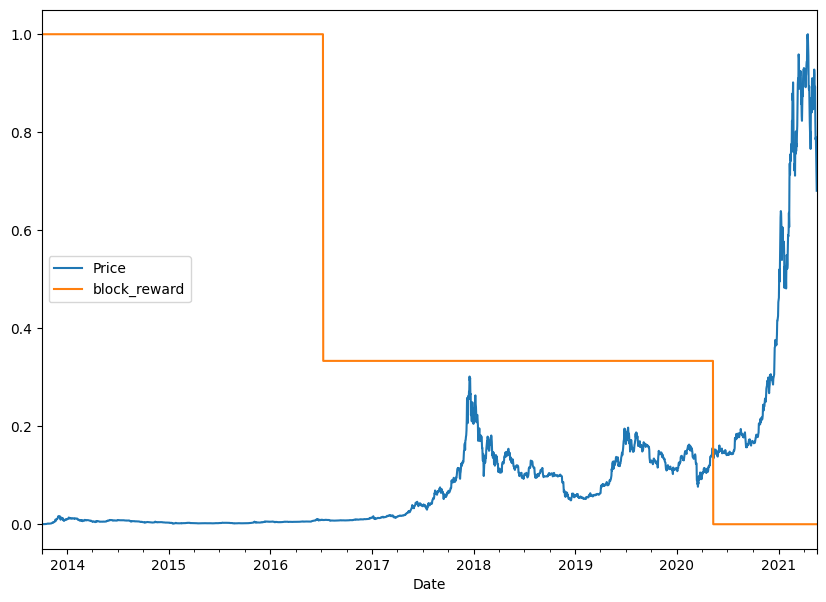

In [81]:
# Plot the block reward/price over time
# Note: Because of the different scales of our values we'll scale them to be between 0 and 1.
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

## Making a windowed dataset with pandas


In [82]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [83]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

Price block_reward    Price+1    Price+2    Price+3  \
Date                                                                  
2013-10-01  123.65499           25        NaN        NaN        NaN   
2013-10-02  125.45500           25  123.65499        NaN        NaN   
2013-10-03  108.58483           25  125.45500  123.65499        NaN   
2013-10-04  118.67466           25  108.58483  125.45500  123.65499   
2013-10-05  121.33866           25  118.67466  108.58483  125.45500   
2013-10-06  120.65533           25  121.33866  118.67466  108.58483   
2013-10-07  121.79500           25  120.65533  121.33866  118.67466   
2013-10-08  123.03300           25  121.79500  120.65533  121.33866   
2013-10-09  124.04900           25  123.03300  121.79500  120.65533   
2013-10-10  125.96116           25  124.04900  123.03300  121.79500   

              Price+4    Price+5    Price+6    Price+7  
Date                                                    
2013-10-01        NaN        NaN        NaN        NaN  
2013-10-02        NaN        NaN        NaN        NaN  
2013-10-03        NaN        NaN        NaN        NaN  
2013-10-04        NaN        NaN        NaN        NaN  
2013-10-05  123.65499        NaN        NaN        NaN  
2013-10-06  125.45500  123.65499        NaN        NaN  
2013-10-07  108.58483  125.45500  123.65499        NaN  
2013-10-08  118.67466  108.58483  125.45500  123.65499  
2013-10-09  121.33866  118.67466  108.58483  125.45500  
2013-10-10  120.65533  121.33866  118.67466  108.58483

In [84]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

block_reward     Price+1     Price+2     Price+3     Price+4  \
Date                                                                       
2013-10-08          25.0  121.794998  120.655327  121.338661  118.674660   
2013-10-09          25.0  123.032997  121.794998  120.655327  121.338661   
2013-10-10          25.0  124.049004  123.032997  121.794998  120.655327   
2013-10-11          25.0  125.961159  124.049004  123.032997  121.794998   
2013-10-12          25.0  125.279663  125.961159  124.049004  123.032997   

               Price+5     Price+6     Price+7  
Date                                            
2013-10-08  108.584831  125.455002  123.654991  
2013-10-09  118.674660  108.584831  125.455002  
2013-10-10  121.338661  118.674660  108.584831  
2013-10-11  120.655327  121.338661  118.674660  
2013-10-12  121.794998  120.655327  121.338661

In [85]:
# View labels
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [86]:
# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

## Model 6: Dense (multivariate time series)


In [87]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  # layers.Dense(128, activation="relu"), # adding an extra layer here should lead to beating the naive model
  layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0, # only print 1 line per epoch
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

In [88]:
# Make sure best model is loaded and evaluate
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 567.8671


567.8670654296875

In [89]:
# Make predictions on multivariate data
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8824.447, 8764.731, 8997.325, 8754.355, 8757.75 , 8707.687,
       8642.85 , 8523.751, 8436.445, 8503.29 ], dtype=float32)>

In [90]:
# Evaluate preds
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 567.867,
 'mse': 1166826.1,
 'rmse': 1080.1973,
 'mape': 2.5640838,
 'mase': 0.99758506}

In [91]:
model_1_results

{'mae': 566.93854,
 'mse': 1165641.8,
 'rmse': 1079.6489,
 'mape': 2.5327604,
 'mase': 0.995954}

## Model 7: N-BEATS algorithm

### Building and testing an N-BEATS block layer

Let's start by building an N-BEATS block layer, we'll write the code first and then discuss what's going on.

In [92]:
# Create NBeatsBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called
    x = inputs
    for layer in self.hidden: # pass inputs through each hidden layer
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [93]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [94]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [95]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [0.6602526  0.33231032 0.3978152  0.6910034  0.2467329  0.3168379
 0.288934  ]
Forecast: 0.7015205025672913


### Preparing data for the N-BEATS algorithm using `tf.data`


In [96]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 7 # how far to lookback

In [97]:
# Create NBEATS data inputs (NBEATS works with univariate time series)
bitcoin_prices.head()

Price
Date                 
2013-10-01  123.65499
2013-10-02  125.45500
2013-10-03  108.58483
2013-10-04  118.67466
2013-10-05  121.33866

In [98]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

Price    Price+1    Price+2    Price+3    Price+4    Price+5  \
Date                                                                           
2013-10-08  123.03300  121.79500  120.65533  121.33866  118.67466  108.58483   
2013-10-09  124.04900  123.03300  121.79500  120.65533  121.33866  118.67466   
2013-10-10  125.96116  124.04900  123.03300  121.79500  120.65533  121.33866   
2013-10-11  125.27966  125.96116  124.04900  123.03300  121.79500  120.65533   
2013-10-12  125.92750  125.27966  125.96116  124.04900  123.03300  121.79500   

              Price+6    Price+7  
Date                              
2013-10-08  125.45500  123.65499  
2013-10-09  108.58483  125.45500  
2013-10-10  118.67466  108.58483  
2013-10-11  121.33866  118.67466  
2013-10-12  120.65533  121.33866

In [99]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [100]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Setting up hyperparameters for N-BEATS algorithm


In [101]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for residual connections


In [102]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


### Building, compiling and fitting the N-BEATS algorithm

In [103]:
 %%time

tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00")

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 299: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 399: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: user 2min 27s, sys: 2.77 s, total: 2min 30s
Wall time: 2min 39s


In [104]:
# Evaluate N-BEATS model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 40ms/step - loss: 577.4403 - mae: 577.4403 - mse: 1188375.2500


[577.4403076171875, 577.4403076171875, 1188375.25]

In [105]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8976.007, 8780.383, 9079.904, 8842.01 , 8742.493, 8821.755,
       8712.653, 8534.12 , 8554.693, 8552.28 ], dtype=float32)>

In [106]:
# Evaluate N-BEATS model predictions
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 577.4403,
 'mse': 1188375.2,
 'rmse': 1090.1262,
 'mape': 2.659143,
 'mase': 1.0144026}

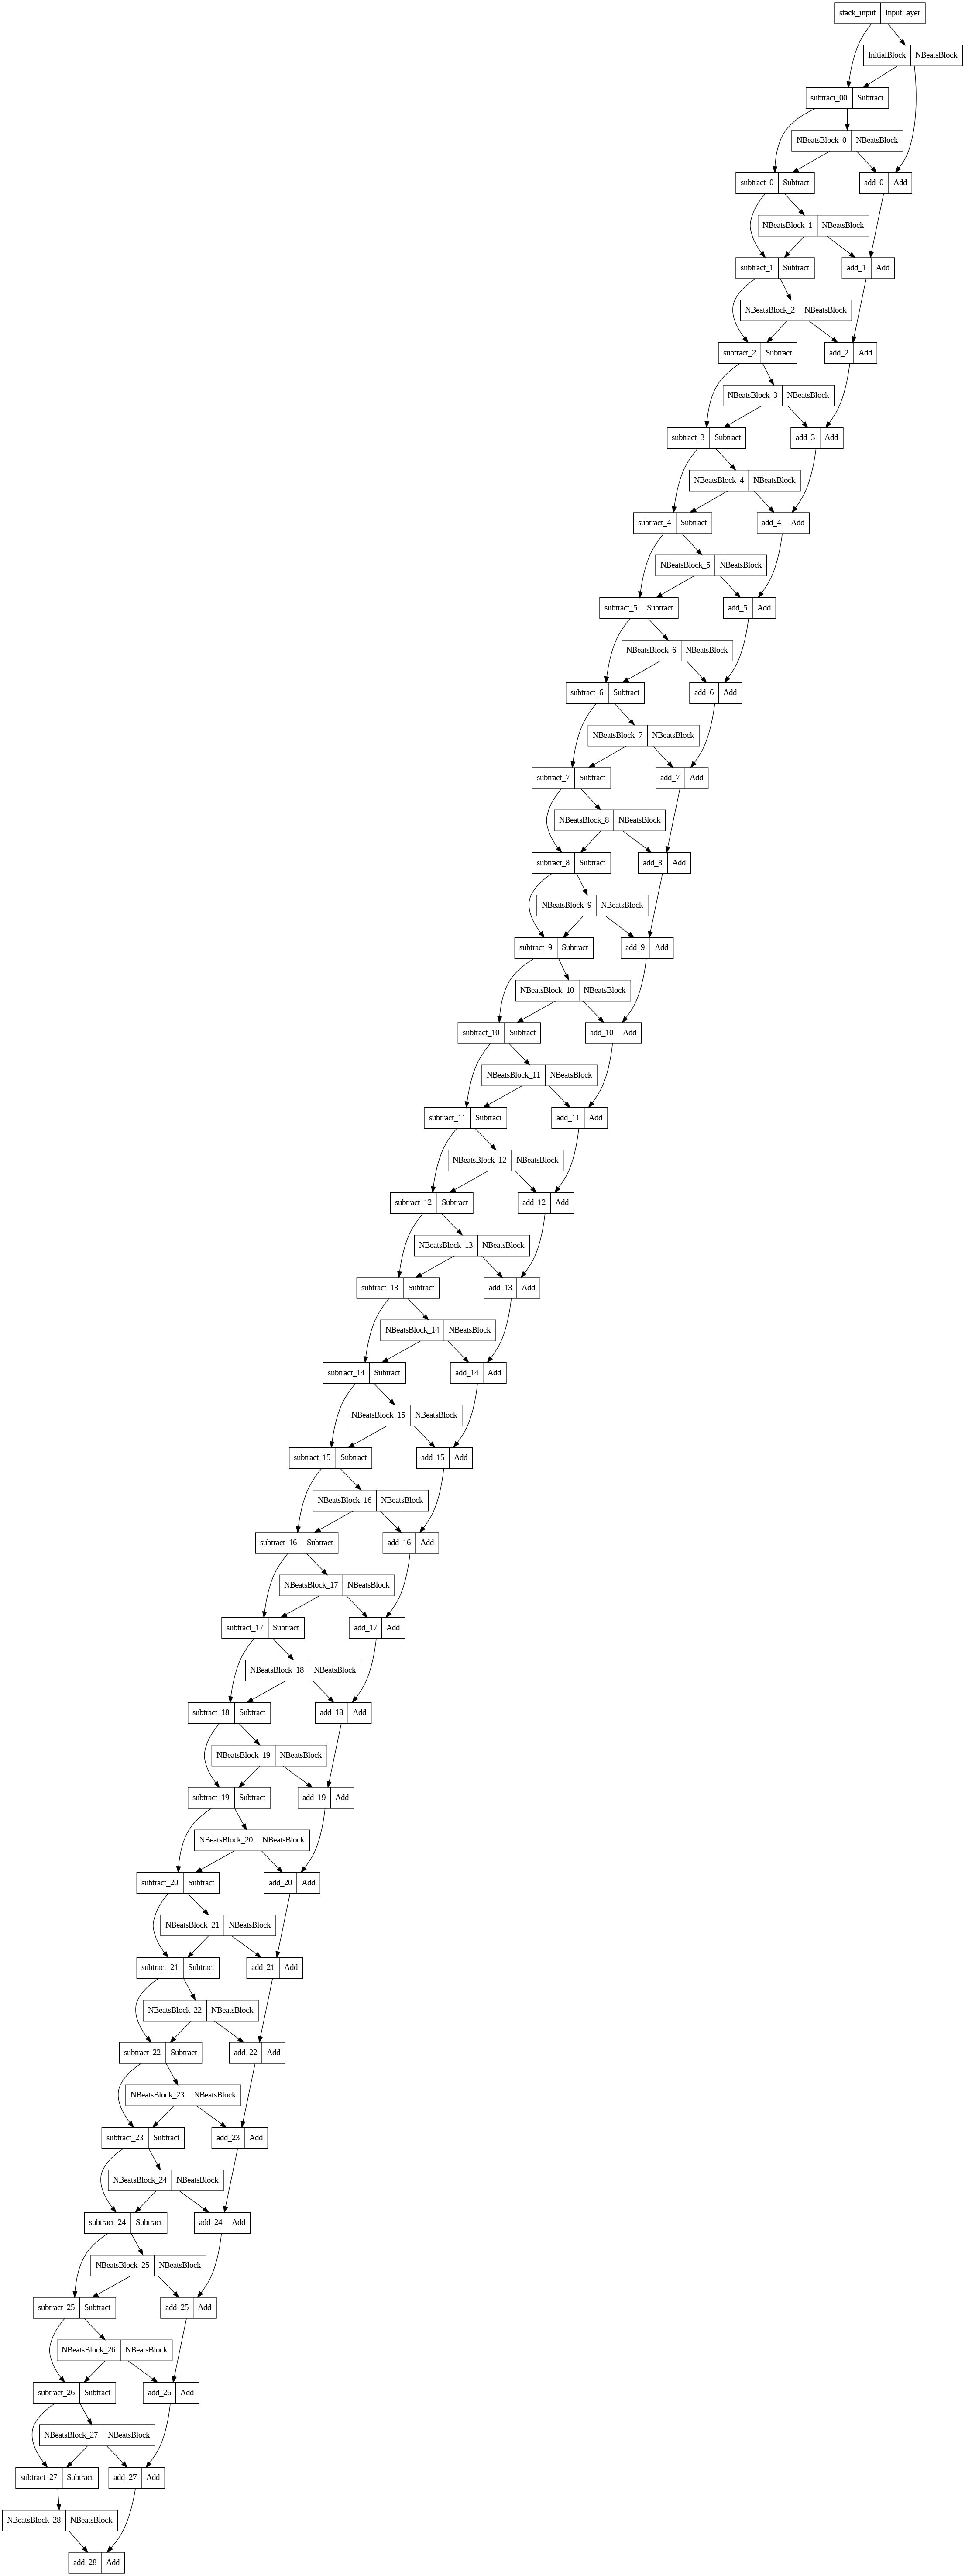

In [107]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_7)

In [108]:
# This will error out unless a "get_config()" method is implemented - this could be extra curriculum
model_7.save(model_7.name)

## Model 8: Creating an ensemble (stacking different models together)



### Constructing and fitting an ensemble of models (using different loss functions)

In [109]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=100,
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
        # interval estimation later: https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])

      # Fit model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                # Add callbacks to prevent training from going/stalling for too long
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])

      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models # return list of trained models

In [110]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 569: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 669: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 219: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 329: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 429: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 129: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 474: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 574: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by redu

### Making predictions with an ensemble model

In [111]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data) # make predictions with current ensemble model
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [112]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 46ms/step


<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8685.933 ,  8615.7705,  8928.672 , ..., 50082.133 , 49307.523 ,
        45993.93  ],
       [ 8748.311 ,  8789.405 ,  9028.187 , ..., 49659.97  , 48652.734 ,
        45852.492 ],
       [ 8804.488 ,  8801.607 ,  9096.782 , ..., 50457.12  , 48551.72  ,
        45804.04  ],
       ...,
       [ 8804.303 ,  8751.271 ,  9113.975 , ..., 50666.68  , 47659.28  ,
        44876.594 ],
       [ 8773.223 ,  8788.355 ,  9077.83  , ..., 49902.254 , 48056.074 ,
        46546.13  ],
       [ 8799.625 ,  8780.016 ,  9101.1   , ..., 50440.492 , 48054.266 ,
        45770.16  ]], dtype=float32)>

In [113]:
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

{'mae': 571.4919,
 'mse': 1152174.2,
 'rmse': 1073.3938,
 'mape': 2.5798173,
 'mase': 1.003953}

### Plotting the prediction intervals (uncertainty estimates) of our ensemble



In [114]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions of multiple randomly initialized deep learning neural networks

  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)

  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std # https://en.wikipedia.org/wiki/1.96

  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  return lower, upper

# Get the upper and lower bounds of the 95%
lower, upper = get_upper_lower(preds=ensemble_preds)

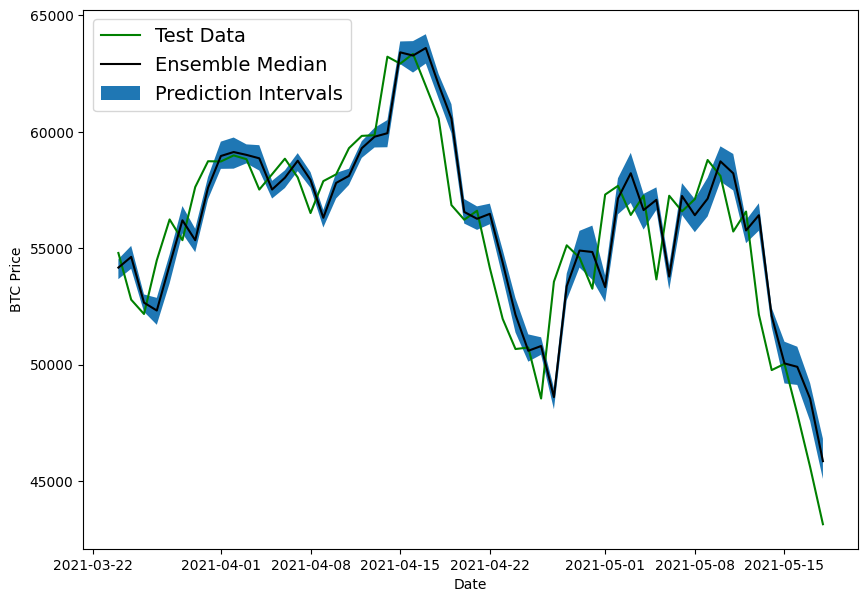

In [115]:
# Get the median values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

## Model 9: Train a model on the full historical data to make predictions into future


In [116]:
bitcoin_prices_windowed.head()

Price block_reward    Price+1    Price+2    Price+3  \
Date                                                                  
2013-10-01  123.65499           25        NaN        NaN        NaN   
2013-10-02  125.45500           25  123.65499        NaN        NaN   
2013-10-03  108.58483           25  125.45500  123.65499        NaN   
2013-10-04  118.67466           25  108.58483  125.45500  123.65499   
2013-10-05  121.33866           25  118.67466  108.58483  125.45500   

              Price+4  Price+5  Price+6  Price+7  
Date                                              
2013-10-01        NaN      NaN      NaN      NaN  
2013-10-02        NaN      NaN      NaN      NaN  
2013-10-03        NaN      NaN      NaN      NaN  
2013-10-04        NaN      NaN      NaN      NaN  
2013-10-05  123.65499      NaN      NaN      NaN

In [117]:
# Train model on entire data to make prediction for the next day
X_all = bitcoin_prices_windowed.drop(["Price", "block_reward"], axis=1).dropna().to_numpy() # only want prices, our future model can be a univariate model
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

In [118]:
# 1. Turn X and y into tensor Datasets
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# 2. Combine features & labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [119]:
tf.random.set_seed(42)

# Create model (nice and simple, just to test)
model_9 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
])

# Compile
model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

# Fit model on all of the data to make future forecasts
model_9.fit(dataset_all,
            epochs=100,
            verbose=0) # don't print out anything, we've seen this all before

### Make predictions on the future


In [120]:
# How many timesteps to predict into the future?
INTO_FUTURE = 14 # since our Bitcoin data is daily, this is for 14 days

![flowchart representation prediction loop to make forecasts and then append forecasts to data and make more forecasts continuously until forecast horizon is exhausted](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-prediction-loop-for-forecasts.png)
*Example flow chart representing the loop we're about to create for making forecasts. Not pictured: retraining a forecasting model every time a forecast is made & new data is acquired. For example, if you're predicting the price of Bitcoin daily, you'd want to retrain your model every day, since each day you're going to have a new data point to work with.*

Alright, let's create a function which returns `INTO_FUTURE` forecasted values using a trained model.

To do so, we'll build the following steps:
1. Function which takes as input:
  * a list of values (the Bitcoin historical data)
  * a trained model (such as `model_9`)
  * a window into the future to predict (our `INTO_FUTURE` variable)
  * the window size a model was trained on (`WINDOW_SIZE`) - the model can only predict on the same kind of data it was trained on
2. Creates an empty list for future forecasts (this will be returned at the end of the function) and extracts the last `WINDOW_SIZE` values from the input values (predictions will start from the last `WINDOW_SIZE` values of the training data)
3. Loop `INTO_FUTURE` times making a prediction on `WINDOW_SIZE` datasets which update to remove the first the value and append the latest prediction
  * Eventually future predictions will be made using the model's own previous predictions as input

In [121]:
# 1. Create function to make predictions into the future
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Makes future forecasts into_future steps after values ends.

  Returns future forecasts as list of floats.
  """
  # 2. Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] # only want preds from the last window (this will get updated)

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time
  for _ in range(into_future):

    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return future_forecast

In [122]:
# Make forecasts into future of the price of Bitcoin
# Note: if you're reading this at a later date, you may already be in the future, so the forecasts
# we're making may not actually be forecasts, if that's the case, readjust the training data.
future_forecast = make_future_forecast(values=y_all,
                                       model=model_9,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 71ms/step
Predicting on: 
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 55494.171875

1/1 [==============================] - 0s 23ms/step
Predicting on: 
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55494.171875  ] -> Prediction: 51162.50390625

1/1 [==============================] - 0s 23ms/step
Predicting on: 
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 55494.171875   51162.50390625] -> Prediction: 49419.3046875

1/1 [==============================] - 0s 29ms/step
Predicting on: 
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55494.171875   51162.50390625 49419.3046875 ] -> Prediction: 48501.8203125

1/1 [==============================] - 0s 27ms/step
Predicting on: 
 [47885.62525472 45604.61575361 43144.47129086 55494.171875
 51162.50390625 49419.3046875  48501.8203125

In [123]:
future_forecast[:10]

[55494.17,
 51162.504,
 49419.305,
 48501.82,
 47018.234,
 46700.51,
 48845.37,
 53919.08,
 50164.977,
 48738.906]

### Plot future forecasts


In [124]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values from ranging from start_date to start_date+horizon.

  start_date: date to start range (np.datetime64)
  into_future: number of days to add onto start date for range (int)
  offset: number of days to offset start_date by (default 1)
  """
  start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range between start date and end date

The start date of our forecasted dates will be the last date of our dataset.

In [125]:
# Last timestep of timesteps (currently in np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-05-18 00:00:00')

In [126]:
# Get next two weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

In [127]:
# Insert last timestep/final price so the graph doesn't look messed
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])
next_time_steps, future_forecast

(array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
        '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
        '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
        '2021-05-30', '2021-05-31', '2021-06-01'], dtype='datetime64[D]'),
 array([43144.473, 55494.17 , 51162.504, 49419.305, 48501.82 , 47018.234,
        46700.51 , 48845.37 , 53919.08 , 50164.977, 48738.906, 47897.137,
        47781.28 , 48940.47 , 51161.223], dtype=float32))

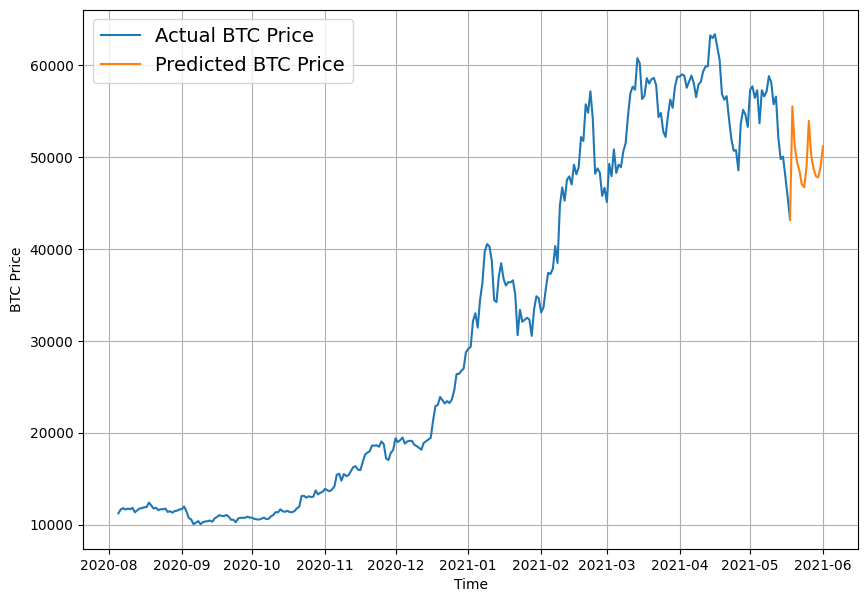

In [128]:
# Plot future price predictions of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, btc_price, start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

## Model 10: Why forecasting is BS (the turkey problem ðŸ¦ƒ)

When creating any kind of forecast, you must keep the **turkey problem** in mind.

The **turkey problem** is an analogy for when your observational data (your historical data) fails to capture a future event which is catostrophic and could lead you to ruin.

The story goes, a turkey lives a good life for 1000 days, being fed every day and taken care of by its owners until the evening before Thanksgiving.

Based on the turkey's observational data, it has no reason to believe things shouldn't keep going the way they are.

In other words, how could a turkey possibly predict that on day 1001, after 1000 consectutive good days, it was about to have a far from ideal day.


How does this relate to predicting the price of Bitcoin (or the price of any stock or figure in an open market)?

You could have the historical data of Bitcoin for its entire existence and build a model which predicts it perfectly.

But then one day for some unknown and unpredictable reason, the price of Bitcoin plummets 100x in a single day.

Of course, this kind of scenario is unlikely.

But that doesn't take away from its significance.

Think about it in your own life, how many times have the most significant events happened seemingly out of the blue?

As in, you could go to a cafe and run into the love of your life, despite visiting the same cafe for 10-years straight and never running into this person before.

The same thing goes for predicting the price of Bitcoin, you could make money for 10-years straight and then lose it all in a single day.

It doesn't matter how many times you get paid, it matters the amount you get paid.

> ðŸ“– **Resource:** If you'd like to learn more about the turkey problem, I'd recommend the following:
* [Explaining both the XIV trade and why forecasting is BS](https://youtu.be/hRwimmE2wEk) by Nassim Taleb
* [*The Black Swan*](https://en.wikipedia.org/wiki/The_Black_Swan:_The_Impact_of_the_Highly_Improbable) by Nassim Taleb (epsecially Chapter 4 which outlines and discusses the turkey problem)

Let's get specific and see how the turkey problem effects us modelling the historical and future price of Bitcoin.

To do so, we're going to manufacture a highly unlikely data point into the historical price of Bitcoin, the price falling 100x in one day.

> ðŸ”‘ **Note:** A very unlikely and unpredictable event such as the price of Bitcoin falling 100x in a single day (note: the adjective "unlikely" is based on the historical price changes of Bitcoin) is also referred to a [**Black Swan** event](https://en.wikipedia.org/wiki/Black_swan_theory). A Black Swan event is an unknown unknown, you have no way of predicting whether or not it will happen but these kind of events often have a large impact.

In [129]:
# Let's introduce a Turkey problem to our BTC data (price BTC falls 100x in one day)
btc_price_turkey = btc_price.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

In [130]:
# Manufacture an extra price on the end (to showcase the Turkey problem)
btc_price_turkey[-10:]

[58788.2096789273,
 58102.1914262342,
 55715.5466512869,
 56573.5554719043,
 52147.8211869823,
 49764.1320815975,
 50032.6931367648,
 47885.6252547166,
 45604.6157536131,
 431.44471290860304]

In [131]:
# Get the timesteps for the turkey problem
btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

array(['2021-05-09T00:00:00.000000000', '2021-05-10T00:00:00.000000000',
       '2021-05-11T00:00:00.000000000', '2021-05-12T00:00:00.000000000',
       '2021-05-13T00:00:00.000000000', '2021-05-14T00:00:00.000000000',
       '2021-05-15T00:00:00.000000000', '2021-05-16T00:00:00.000000000',
       '2021-05-17T00:00:00.000000000', '2021-05-18T00:00:00.000000000'],
      dtype='datetime64[ns]')

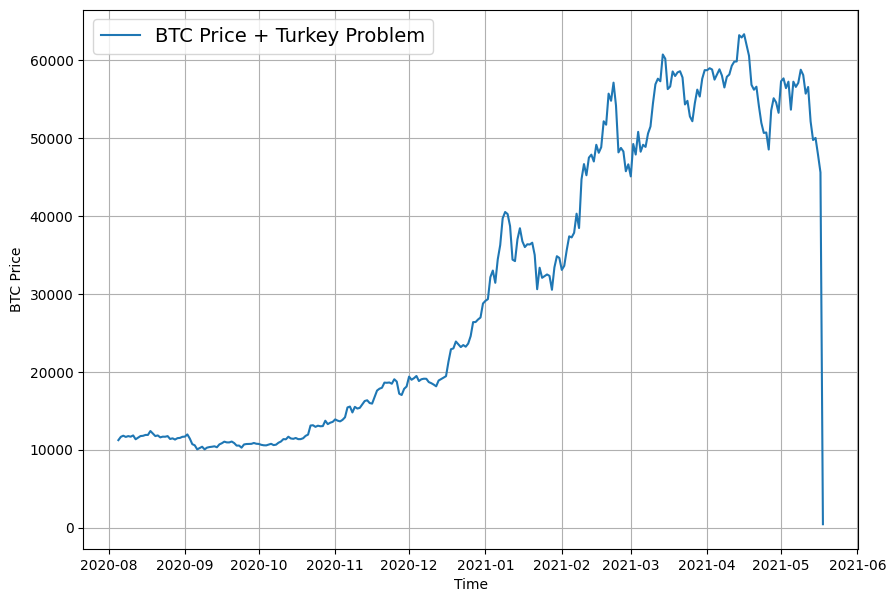

In [132]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=btc_timesteps_turkey,
                 values=btc_price_turkey,
                 format="-",
                 label="BTC Price + Turkey Problem",
                 start=2500)

In [133]:
# Create train and test sets for turkey problem data
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

(2224, 556, 2224, 556)

### Building a turkey model (model to predict on turkey data)


In [134]:
# Clone model 1 architecture for turkey model and fit the turkey model on the turkey data
turkey_model = tf.keras.models.clone_model(model_1)
turkey_model._name = "Turkey_Model"
turkey_model.compile(loss="mae",
                     optimizer=tf.keras.optimizers.Adam())
turkey_model.fit(X_train, y_train,
                 epochs=100,
                 verbose=0,
                 validation_data=(X_test, y_test),
                 callbacks=[create_model_checkpoint(turkey_model.name)])

In [135]:
# Evaluate turkey model on test data
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 690.4515


690.4515380859375

In [136]:
# Load best model and evaluate on test data
turkey_model = tf.keras.models.load_model("model_experiments/Turkey_Model/")
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 639.5823


639.582275390625

In [137]:
# Make predictions with Turkey model
turkey_preds = make_preds(turkey_model, X_test)
turkey_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8819.346, 8778.884, 9023.233, 8759.591, 8748.364, 8718.581,
       8658.161, 8524.56 , 8441.988, 8516.684], dtype=float32)>

In [138]:
# Evaluate turkey preds
turkey_results = evaluate_preds(y_true=y_test,
                                y_pred=turkey_preds)
turkey_results

{'mae': 17138.99,
 'mse': 615082560.0,
 'rmse': 23731.012,
 'mape': 121.47641,
 'mase': 26.522646}

In [139]:
model_1_results

{'mae': 566.93854,
 'mse': 1165641.8,
 'rmse': 1079.6489,
 'mape': 2.5327604,
 'mase': 0.995954}

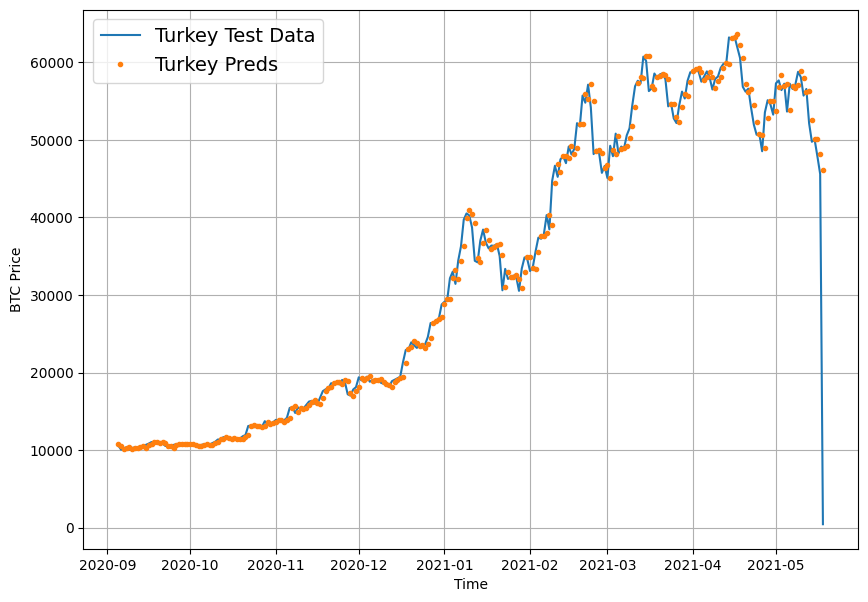

In [140]:
plt.figure(figsize=(10, 7))
# plot_time_series(timesteps=btc_timesteps_turkey[:split_size], values=btc_price_turkey[:split_size], label="Train Data")
offset=300
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=btc_price_turkey[-len(y_test):],
                 format="-",
                 label="Turkey Test Data", start=offset)
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=turkey_preds,
                 label="Turkey Preds",
                 start=offset);

## Compare Models


In [141]:
# Compare different model results (w = window, h = horizon, e.g. w=7 means a window size of 7)
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_8_NBEATs": model_7_results,
                              "model_9_ensemble": ensemble_results,
                              "model_10_turkey": turkey_results}).T
model_results.head(10)

mae           mse          rmse        mape  \
naive_model             567.980225  1.147547e+06   1071.236206    2.516525   
model_1_dense_w7_h1     566.938538  1.165642e+06   1079.648926    2.532760   
model_2_dense_w30_h1    603.898010  1.229239e+06   1108.710327    2.785187   
model_3_dense_w30_h7   1235.973999  5.406066e+06   1429.782837    5.640371   
model_4_CONV1D          572.627014  1.179893e+06   1086.229004    2.566138   
model_5_LSTM            598.158081  1.280961e+06   1131.795532    2.691267   
model_6_multivariate    567.867004  1.166826e+06   1080.197266    2.564084   
model_8_NBEATs          577.440308  1.188375e+06   1090.126221    2.659143   
model_9_ensemble        571.491882  1.152174e+06   1073.393799    2.579817   
model_10_turkey       17138.990234  6.150826e+08  23731.011719  121.476410   

                           mase  
naive_model            0.999570  
model_1_dense_w7_h1    0.995954  
model_2_dense_w30_h1   1.055620  
model_3_dense_w30_h7   2.199347  
model_4_CONV1D         1.005947  
model_5_LSTM           1.050798  
model_6_multivariate   0.997585  
model_8_NBEATs         1.014403  
model_9_ensemble       1.003953  
model_10_turkey       26.522646

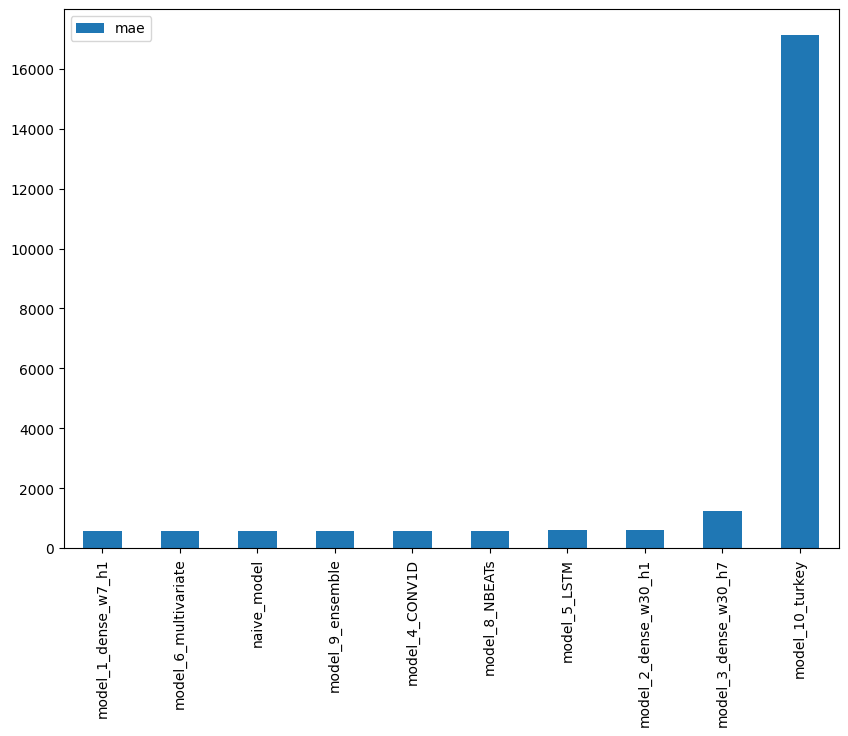

In [142]:
# Sort model results by MAE and plot them
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar");